In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.2 MB/s eta 0:00:00


In [3]:
!pip install PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=89b70b012d83ff12f8a161ceab66d2fc123af76a5ca622d68afd0a7db2397f2f
  Stored in directory: /root/.cache/pip/wheels/6c/10/da/a5b513f5b3916fc391c20ee7b4633e5cf3396d570cdd74970f
Successfully built PyDrive


In [4]:
# General-purpose imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import quote
import webbrowser
import random
from collections import defaultdict
from base64 import b64decode

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced-learn imports
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, GlobalAveragePooling2D, SeparableConv2D, Multiply
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2

# For AdamW optimizer (if available)
try:
    from tensorflow.keras.optimizers import AdamW
except ImportError:
    AdamW = Adam

# IPython displays
from IPython.display import display

# Kerastuner imports
from kerastuner.tuners import RandomSearch

# Google Colab imports
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

/tmp/ipython-input-4035724408.py:46: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
# Kaggle imports
import kagglehub

import zipfile
import os

# Path to your ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/fer2013/fer2013.zip"

# Destination folder where contents will be extracted
extract_path = "/content/fer2013"

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folders/files
print(os.listdir(extract_path))


['train', 'test']


Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Training class distribution:


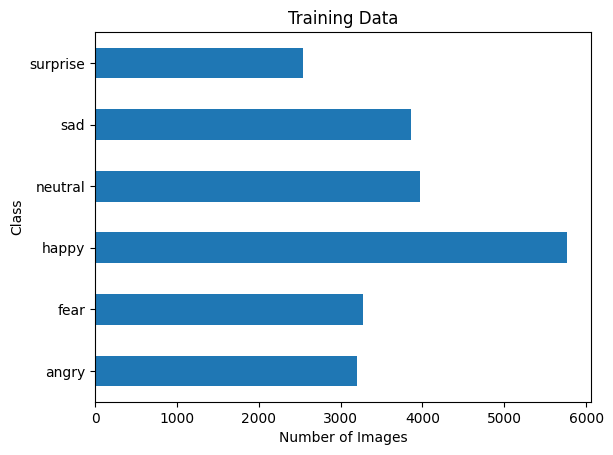

Validation class distribution:


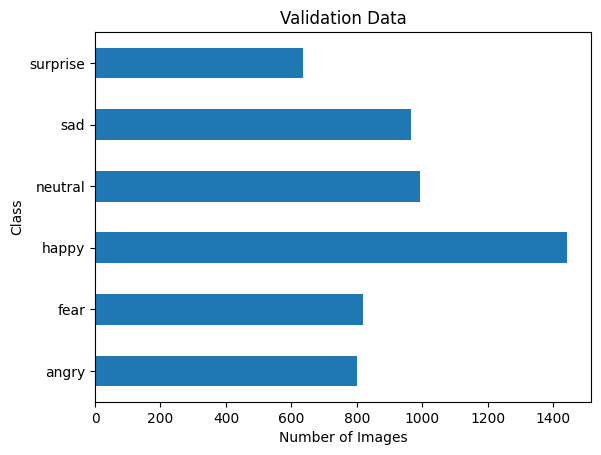

Test class distribution:


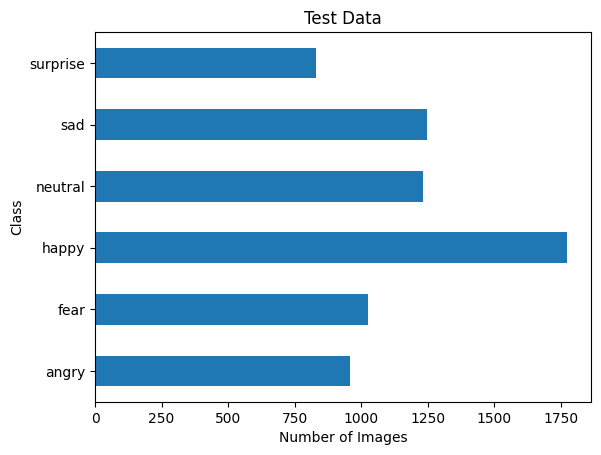

Building DenseNet201 with Attention Model...
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

DenseNet201 with Attention Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 48, 48, 3) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet201         │ (None, 1, 1,      │ 18,321,984 │ lambda[0][0]      │
│ (Functional)        │ 1920)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1920)      │          0 │ densenet201[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1920)      │          0 │ densenet201[0][0] │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 120)       │    230,520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120)       │    230,520 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1920)      │    232,320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1920)      │    232,320 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1920)      │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1920)      │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ activation[0][0]  │
│                     │ 1920)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1,      │          0 │ densenet201[0][0… │
│                     │ 1920)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 1, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 1, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1, 2)   │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 1, 1)   │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 1,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 1920)             │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1920)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,887,385 (83.49 MB)

 Trainable params: 7,139,097 (27.23 MB)

 Non-trainable params: 14,748,288 (56.26 MB)


Training DenseNet201 with Attention Model...
Epoch 1/80
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1861 - loss: 2.5254
Epoch 1: val_accuracy improved from -inf to 0.28705, saving model to best_densenet201_attention_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 243s 394ms/step - accuracy: 0.1861 - loss: 2.5251 - val_accuracy: 0.2871 - val_loss: 1.7682 - learning_rate: 1.0000e-04
Epoch 2/80
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2209 - loss: 2.2105
Epoch 2: val_accuracy improved from 0.28705 to 0.30138, saving model to best_densenet201_attention_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.2209 - loss: 2.2104 - val_accuracy: 0.3014 - val_loss: 1.7499 - learning_rate: 1.0000e-04
Epoch 3/80
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2396 - loss: 2.0599
Epoch 3: val_accuracy improved from 0.30138 to 0.30845, saving model to best_densenet201_attention_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.2396 - 

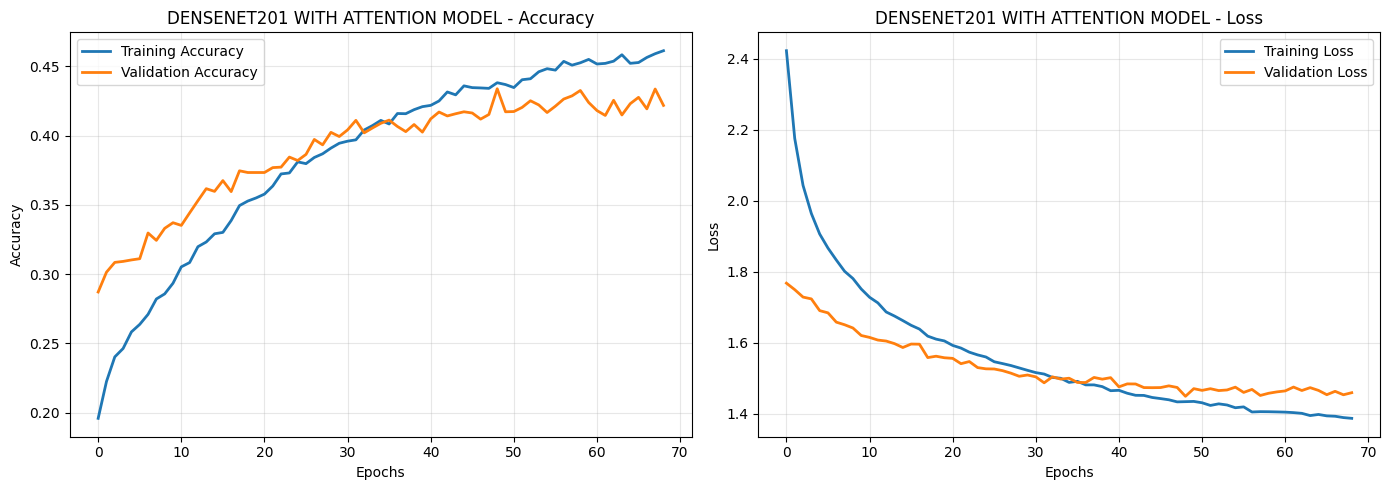


Evaluating DenseNet201 with Attention Model...
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step
Classification Report for DENSENET201 WITH ATTENTION
              precision    recall  f1-score   support

       angry       0.36      0.30      0.33       958
        fear       0.39      0.14      0.21      1024
       happy       0.51      0.75      0.60      1774
     neutral       0.40      0.44      0.42      1233
         sad       0.43      0.29      0.34      1247
    surprise       0.53      0.66      0.59       831

    accuracy                           0.46      7067
   macro avg       0.44      0.43      0.42      7067
weighted avg       0.44      0.46      0.43      7067



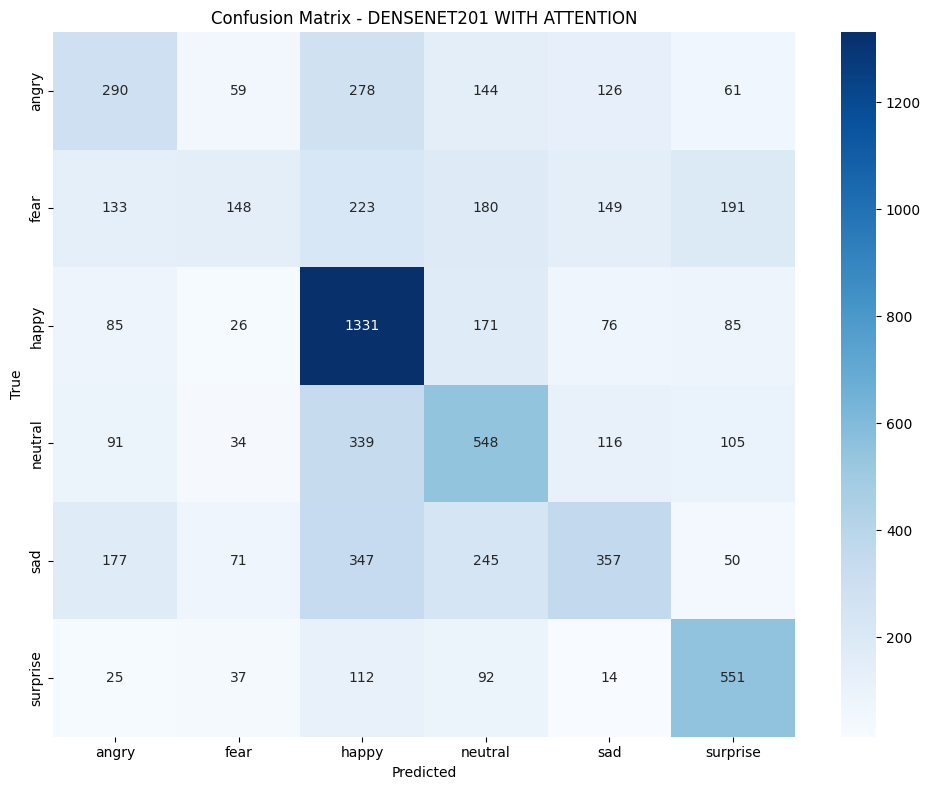

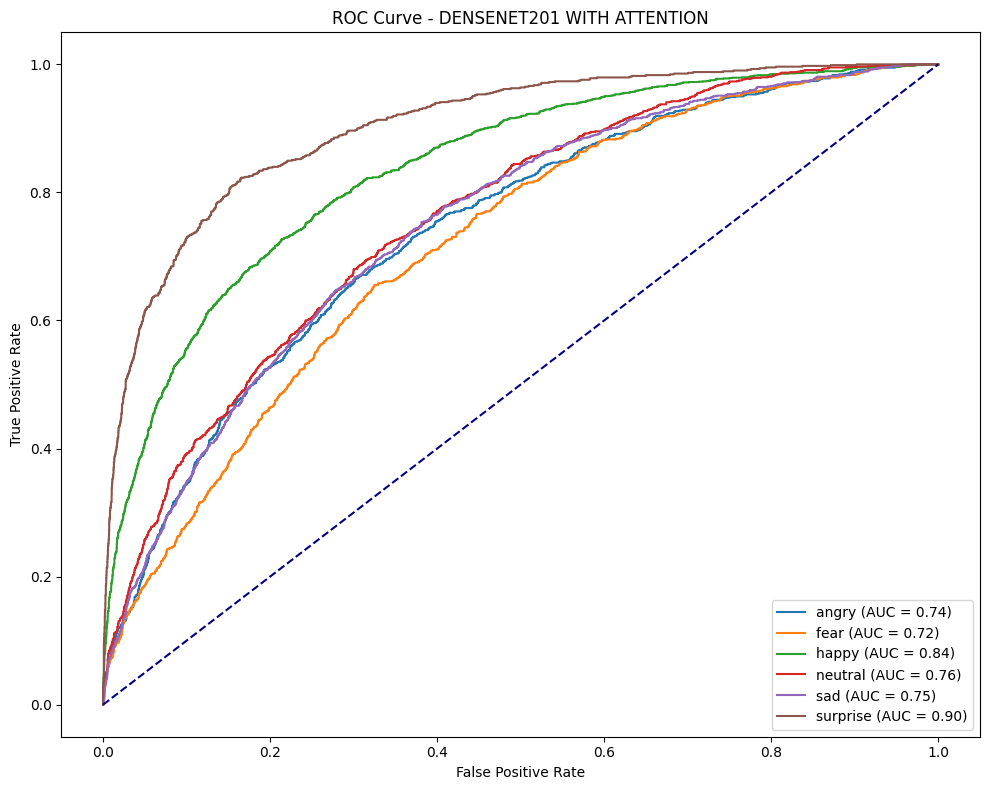

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


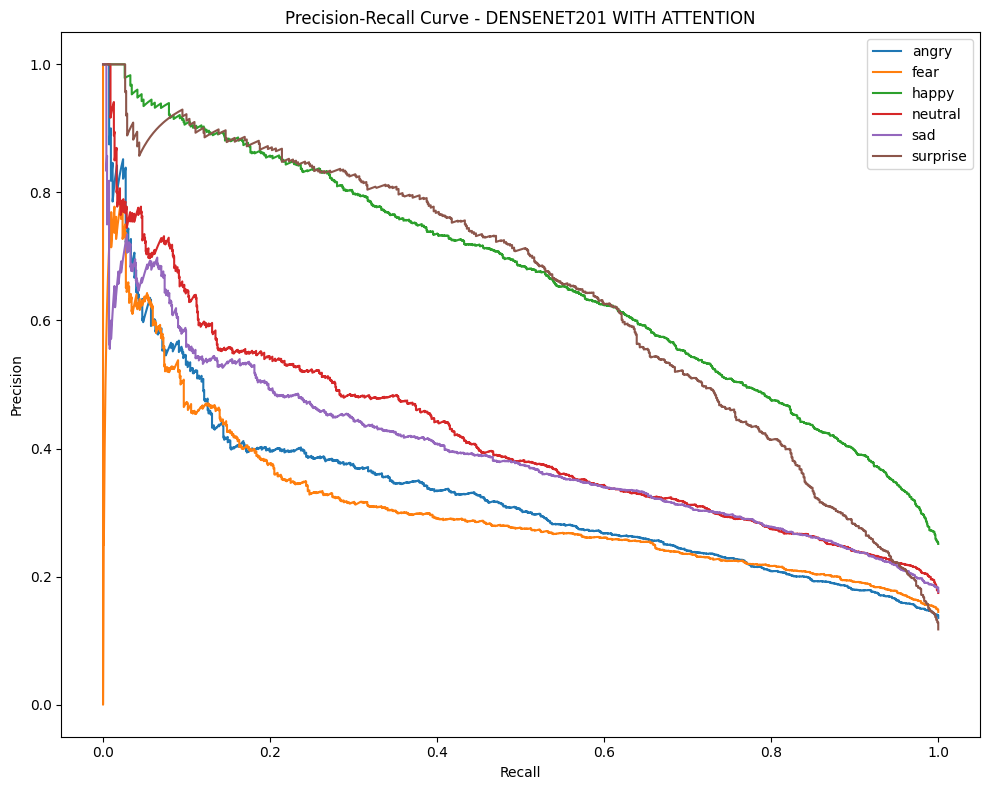

111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.3854 - loss: 1.4974

🎯 DENSENET201 WITH ATTENTION - Final Test Accuracy: 0.4563, Test Loss: 1.3826

Saving model...
Model saved successfully as 'fer_densenet201_attention_model.keras'!


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Multiply, Activation, Reshape, Permute, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# ---------------------------- Configurations ---------------------------- #
IMAGE_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 80

TRAIN_PATH = "/content/fer2013/train"
TEST_PATH = "/content/fer2013/test"
SELECTED_CLASSES = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# ---------------------------- Attention Mechanisms ---------------------------- #
def channel_attention(input_tensor, reduction_ratio=8):
    """Channel Attention Module (CAM)"""
    channels = input_tensor.shape[-1]

    # Global Average Pooling
    gap = GlobalAveragePooling2D()(input_tensor)
    gap = Dense(channels // reduction_ratio, activation='relu')(gap)
    gap = Dense(channels, activation='sigmoid')(gap)

    # Global Max Pooling
    gmp = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    gmp = Dense(channels // reduction_ratio, activation='relu')(gmp)
    gmp = Dense(channels, activation='sigmoid')(gmp)

    # Combine both pooling methods
    attention = tf.keras.layers.Add()([gap, gmp])
    attention = Activation('sigmoid')(attention)

    # Reshape and multiply with input
    attention = Reshape((1, 1, channels))(attention)
    return Multiply()([input_tensor, attention])

def spatial_attention(input_tensor):
    """Spatial Attention Module (SAM)"""
    # Average and max pooling along channel axis
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)

    # Concatenate and apply convolution
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

    return Multiply()([input_tensor, attention])

def cbam_attention(input_tensor, reduction_ratio=8):
    """Convolutional Block Attention Module (CBAM)"""
    # Channel attention first
    x = channel_attention(input_tensor, reduction_ratio)
    # Then spatial attention
    x = spatial_attention(x)
    return x

# ---------------------------- Utility Functions ---------------------------- #
def plot_class_distribution(generator, title):
    """Plot class distribution of a dataset."""
    class_counts = generator.classes
    class_labels = list(generator.class_indices.keys())
    counts = pd.Series(class_counts).value_counts(sort=False)
    counts.index = [class_labels[i] for i in counts.index]
    counts.plot(kind='barh', title=title)
    plt.xlabel('Number of Images')
    plt.ylabel('Class')
    plt.show()

# ---------------------------- Grayscale Data Generators ---------------------------- #
def create_grayscale_generators(train_path, test_path, img_size, batch_size, selected_classes):
    """Create grayscale data generators with enhanced augmentation."""
    train_preprocessor = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        fill_mode='nearest',
        validation_split=0.2
    )

    test_preprocessor = ImageDataGenerator(rescale=1./255)

    train_generator = train_preprocessor.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        classes=selected_classes,
        shuffle=True
    )

    validation_generator = train_preprocessor.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
        classes=selected_classes,
        shuffle=False
    )

    test_generator = test_preprocessor.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
        classes=selected_classes
    )

    return train_generator, validation_generator, test_generator

# ---------------------------- DenseNet201 Model Building Function ---------------------------- #
def build_densenet201_with_attention(input_shape, num_classes):
    """Build DenseNet201 model with CBAM attention mechanism."""
    # Create base model
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through DenseNet201
    x = base_model(x, training=False)

    # Add CBAM attention
    x = cbam_attention(x, reduction_ratio=16)

    # Enhanced classifier head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Fine-tuning strategy for DenseNet201
    base_model.trainable = True
    # Freeze early layers, fine-tune later layers
    # DenseNet201 has more layers, so we freeze more layers
    for layer in base_model.layers[:-100]:
        layer.trainable = False

    return model

# ---------------------------- Enhanced Callbacks ---------------------------- #
def get_enhanced_callbacks(model_name):
    """Get enhanced callbacks for training."""
    checkpoint = ModelCheckpoint(
        f"best_{model_name}_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]

# ---------------------------- Model Evaluation ---------------------------- #
def evaluate_and_plot_metrics(model, generator, selected_classes, title):
    """Evaluate model and plot confusion matrix, ROC curve, and precision-recall curve."""
    predictions = model.predict(generator)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes

    print(f"Classification Report for {title}")
    print(classification_report(true_classes, pred_classes, target_names=selected_classes))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    true_binary = tf.keras.utils.to_categorical(true_classes, num_classes=len(selected_classes))
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(selected_classes):
        fpr, tpr, _ = roc_curve(true_binary[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.title(f"ROC Curve - {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------- PR Curve Plot ---------------------------- #
def plot_precision_recall_curve(generator, predictions, selected_classes, title):
    """Plot Precision-Recall curve for each class."""
    true_classes = generator.classes
    true_binary = tf.keras.utils.to_categorical(true_classes, num_classes=len(selected_classes))

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(selected_classes):
        precision, recall, _ = precision_recall_curve(true_binary[:, i], predictions[:, i])
        plt.plot(recall, precision, label=f'{class_name}')

    plt.title(f'Precision-Recall Curve - {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------- Training History Plot ---------------------------- #
def plot_training_history(history, title):
    """Plot training and validation accuracy and loss over epochs."""
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ---------------------------- Pipeline Execution ---------------------------- #
if __name__ == "__main__":
    # Use grayscale generators
    train_generator, validation_generator, test_generator = create_grayscale_generators(
        TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE, SELECTED_CLASSES
    )

    # Print class distributions
    print("Training class distribution:")
    plot_class_distribution(train_generator, "Training Data")

    print("Validation class distribution:")
    plot_class_distribution(validation_generator, "Validation Data")

    print("Test class distribution:")
    plot_class_distribution(test_generator, "Test Data")

    # Build DenseNet201 model with attention
    print("Building DenseNet201 with Attention Model...")
    densenet201_attention_model = build_densenet201_with_attention((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
    densenet201_attention_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Print model summary
    print("\nDenseNet201 with Attention Model Summary:")
    densenet201_attention_model.summary()

    # Train model
    print(f"\n{'='*50}")
    print("Training DenseNet201 with Attention Model...")
    print(f"{'='*50}")

    history = densenet201_attention_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=get_enhanced_callbacks('densenet201_attention'),
        verbose=1
    )

    # Plot training history
    print("\nPlotting Training History...")
    plot_training_history(history, "DENSENET201 WITH ATTENTION MODEL")

    # Evaluate model
    print(f"\n{'='*50}")
    print("Evaluating DenseNet201 with Attention Model...")
    print(f"{'='*50}")

    evaluate_and_plot_metrics(densenet201_attention_model, test_generator, SELECTED_CLASSES, "DENSENET201 WITH ATTENTION")

    # Generate predictions and plot PR curve
    predictions = densenet201_attention_model.predict(test_generator)
    plot_precision_recall_curve(test_generator, predictions, SELECTED_CLASSES, "DENSENET201 WITH ATTENTION")

    # Calculate final test accuracy
    test_loss, test_acc = densenet201_attention_model.evaluate(test_generator)
    print(f"\n🎯 DENSENET201 WITH ATTENTION - Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # Save model
    print("\nSaving model...")
    densenet201_attention_model.save('fer_densenet201_attention_model.keras')
    print("Model saved successfully as 'fer_densenet201_attention_model.keras'!")